# <div align="center"><b> TP1 - VPC3 - MIA </b></div>

<div align="right">📝 <em><small><font color='Gray'>Nota:</font></small></em></div>

<div align="right"> <em><small><font color='Gray'> La funcionalidad de visualización de jupyter notebooks en <a href="https://github.com/" target="_blank">github</a> es solamente un preview.</font></small></em> </div>

<div align="right"> <em><small><font color='Gray'> Para mejor visualización se sugiere utilizar el visualizador recomendado por la comunidad: <a href="https://nbviewer.org/" target="_blank">nbviewer</a></font></small></em> </div>

<div align="right"> <em><small><font color='Gray'> Puedes a acceder al siguiente enlace para ver este notebook en dicha página: <a href="https://nbviewer.org/github/brunomaso1/uba-mia/blob/mia-vpc3/mia-vpc3/Practicos/Practico%201/practico1.ipynb">Ruta archivo</a></font></small></em> </div>

* * *

<style>
/* Limitar la altura de las celdas de salida en html */
.jp-OutputArea.jp-Cell-outputArea {
    max-height: 500px;
}
</style>

🛻 <em><font color='MediumSeaGreen'>  Instalaciones: </font></em> 🛻


Este notebook utiliza [Poetry](https://python-poetry.org/) para la gestión de dependencias.
Primero instala Poetry siguiendo las instrucciones de su [documentación oficial](https://python-poetry.org/docs/#installation).
Luego ejecuta el siguiente comando para instalar las dependencias necesarias y activar el entorno virtual:

- Bash:
```bash
poetry install
eval $(poetry env activate)
```

- PowerShell:
```powershell
poetry install
Invoke-Expression (poetry env activate)
```

> 📝 <em><font color='Gray'>Nota:</font></em> Para agregar `pytorch` utilizando Poetry, se utiliza el siguiente comando:
> ```bash
> # Más info: https://github.com/python-poetry/poetry/issues/6409
> potery source add --priority explicit pytorch_gpu https://download.pytorch.org/whl/cu128 # Seleccionar la wheel adecuada para tu GPU
> poetry add --source pytorch_gpu torch torchvision 
> ```

<!-- NOTA: Está puesto a fuego el wheel para mi máquina, pero se puede cambiar a la que corresponda para cada uno. -->

✋ <em><font color='DodgerBlue'>Importaciones:</font></em> ✋

In [4]:
import torch
from torch import Tensor
import torch.nn as nn
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image
import math

🔧 <em><font color='tomato'>Configuraciones:</font></em> 🔧


In [5]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' # Establece el dispositivo.
print(f'Dispositivo actual: {DEVICE}')

Dispositivo actual: cuda


<div align="center">✨Datos del proyecto:✨</div>

<p></p>

<div align="center">

| Subtitulo       | Practico 1 - Visión por computadora 3 - FIUBA                                                                                                              |
| --------------- | -------------------------------------------------------------------------------------------------------------------------------------- |
| **Descrpción**  | Patch embedding + positional encoding (VIT)                                                         |
| **Integrantes** | Bruno Masoller (brunomaso1@gmail.com)                                                                                                  |

</div>

## Consinga

### Vision Transformer (ViT)

El **Vision Transformer (ViT)** es un modelo innovador para la clasificación de imágenes que transforma las imágenes en secuencias de parches más pequeños, comúnmente de $16 \times 16$ píxeles, como se describe en el paper de [Alexey Dosovitskiy et al.](https://openreview.net/pdf?id=YicbFdNTTy)  "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale". Cada parche se considera como una "palabra" o "token" y se proyecta en un espacio de características. Mediante la incorporación de cifrados de posición y un token de clasificación, podemos aplicar un Transformer de manera convencional a esta secuencia, permitiendo su entrenamiento para tareas de clasificación de imágenes.

### Embeddings y Cifrado de Posición

#### Embeddings
En el contexto de ViTs, las imágenes son primero divididas en pequeños bloques o patches (como si se cortaran en pequeños cuadrados). Estos patches se tratan como si fueran palabras en un modelo de lenguaje, y a cada uno se le asigna un embedding. Un embedding es simplemente una representación numérica del patch en un espacio de alta dimensión que captura características relevantes del mismo.

Por ejemplo, si divides una imagen de 224x224 píxeles en 16x16 bloques, tendrás 196 patches en total. Cada uno de esos patches se convierte en un vector de embedding, que luego se alimenta al modelo Transformer.

#### Positional Embedding (Cifrado Posicional):

El **embedding posicional** agrega información sobre la ubicación de cada parche en la imagen original. En el paper de Alexey Dosovitskiy et al., se evaluaron varias formas de codificar la información espacial con embebidos posicionales. Se observó que, aunque el uso de embebidos mejora el rendimiento en comparación con no usarlos, no hay diferencias significativas entre los métodos probados. Se concluyó que, dado que el modelo opera a nivel de parches en lugar de píxeles, la forma específica de codificar la posición es menos relevante.
### Proceso de Creación de Embeddings

1. **División en Parches**: La imagen se divide en parches de $N \times N$ píxeles.
   
2. **Generación de Embeddings**: Cada parche se transforma en un embedding que captura su información relevante.

3. **Cifrado de Posición**: Se añade un vector de cifrado de posición a cada embedding. 

   Algunos ejemplos del cifrado:


   *  **Codificación Sinusoidal:** La fórmula sinusoidal para embebidos posicionales (tradicional en Transformers-NLP) genera los valores de los embebidos en función de senos y cosenos. Estos valores dependen directamente de la posición y siguen una periodicidad específica para capturar relaciones posicionales. Es determinista y no se ajusta durante el entrenamiento, ya que los valores están calculados y fijos para cada posición.
   Donde:
       - $pos$ es la posición en la secuencia.
       - $i$ es el índice de la dimensión.
       - $d_{model}$ es la dimensión del modelo.

   $$PE(pos, 2i) = \sin\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)$$

   $$PE(pos, 2i + 1) = \cos\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)$$



   * **Embebido Posicional Aprendido (a ser implementada por el alumno):** los embebidos posicionales se definen como un parámetro de la red neuronal (usando [nn.Parameter](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html)), lo que significa que los valores para el embebido  posicional se aprenden durante el proceso de entrenamiento. Se define embedding, matriz de tamaño (1, num_patches, embed_dim), donde num_patches es el número de parches (posiciones) en la secuencia de la imagen y  embed_dim es la dimensión de los embebidos. La inicialización torch.randn genera valores aleatorios para estos embebidos posicionales, y luego el modelo los optimiza durante el entrenamiento, ajustando los valores en función de los gradientes.

4. **Combinación de Embeddings y Cifrado de Posición**: Se suma cada embedding con su correspondiente cifrado de posición, generando un vector final que contiene tanto la información del contenido del parche como su posición en la imagen.

El resultado es una serie de vectores, cada uno representando un parche y su posición, que se alimentan a las capas del Transformer. Esto permite al modelo aprender no solo sobre las características individuales de cada parche, sino también sobre cómo estos se relacionan entre sí en el contexto de la imagen completa.


![Vision Transformer](vit.gif)

*Crédito: [Phil Wang](https://github.com/lucidrains/vit-pytorch/blob/main/images/vit.gif)*


A continuación, trabajaremos con los **patch embeddings** y la **codificación posicional**, esenciales para que el modelo pueda interpretar las relaciones espaciales en las imágenes. 

### Tareas:

1. **Modificar los parametros:** Cambiar el tamaño de los parches, y la cantidad de dimensiones del embedding. Investigar y describir las ventajas y desventajas de tener más o menos parches/dimensiones.

2. **Implementar embedding posicional aprendido 1D:** Partiendo de ejemplo proporcionado (codificación sinusoidal en clase PositionalEncoding), implementar una clase PositionalEncodingLearned que utilice PyTorch y genere embebidos posicionales aprendidos. Graficar. 


Dispositivo utilizado: cuda
Dimensiones de la imagen original: (1254, 836)
Canales: RGB
Imagen de prueba cargada: raccoon.jpg
Tamaño de la imagen: 900x900
Tamaño del parche: 64x64
Dimensiones de la imagen de prueba: torch.Size([1, 3, 900, 900])


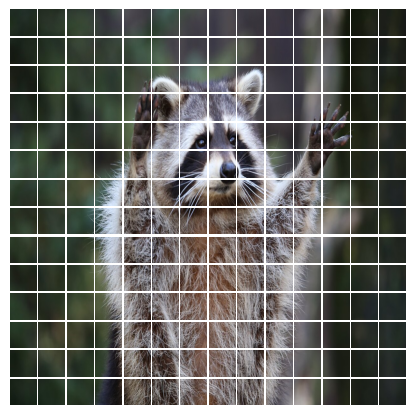

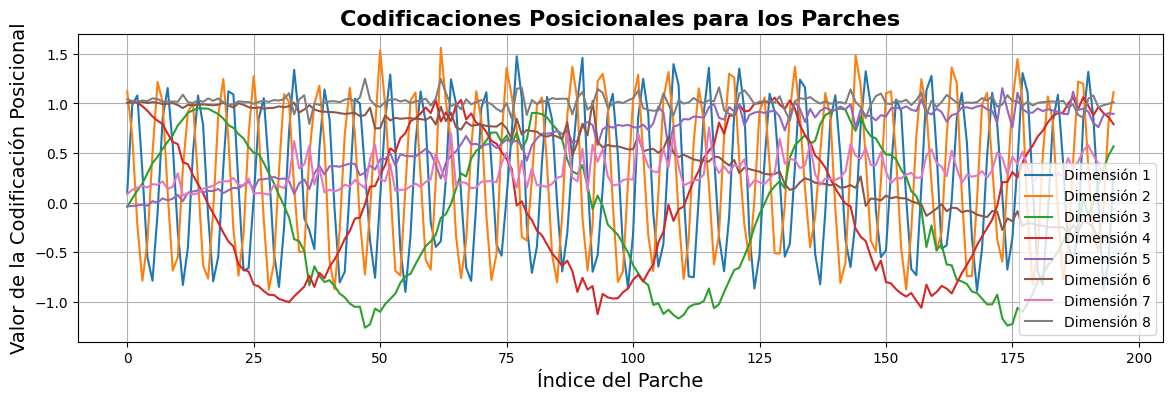

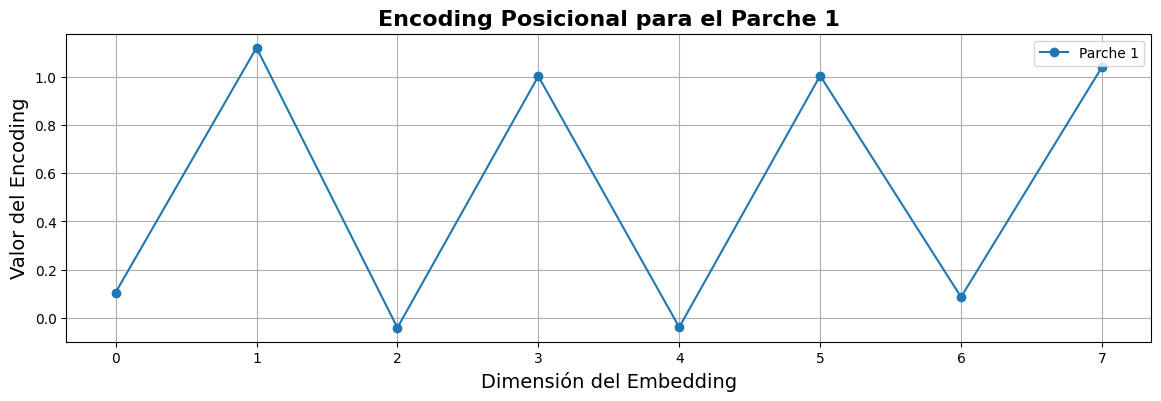

In [6]:
# La configuración, carga y preprocesamiento
class ConfigPreprocess:
    def __init__(self, img_path: str, img_size: int, patch_size: int):
        self.device = (
            "cuda"
            if torch.cuda.is_available()
            else "mps" if torch.backends.mps.is_available() else "cpu"
        )
        print(f"Dispositivo utilizado: {self.device}")

        self.img_path = img_path
        self.img_size = img_size
        self.patch_size = patch_size
        self.test_img = self.load_image()

    def load_image(self):
        return (
            TF.to_tensor(
                Image.open(self.img_path).resize(
                    (self.img_size, self.img_size)
                )  # Dimensiones:
            )
            .unsqueeze(0)  # Añadir dimensión de batch
            .to(self.device)
        )

    def extract_patches(self, image: Tensor) -> Tensor:
        """
        Extrae parches 2D de la imagen tensorial de entrada.

        Args:
            image (Tensor): Tensor de la imagen de entrada con forma (B, C, H, W).

        Returns:
            Tensor: Parches extraídos con forma (B, num_patches, patch_size, patch_size).

        Resumen:
        Este método utiliza la función `unfold` para extraer ventanas deslizantes (parches) de la imagen.
        El primer `unfold` se aplica a la altura (dimensión 1) y el segundo al ancho (dimensión 2).
        El tamaño de la ventana deslizante es `patch_size` con un paso igual a `patch_size`, asegurando que no haya superposición.
        Después de aplicar `unfold`, el método `contiguous` asegura que los datos estén almacenados en memoria contigua.
        Finalmente, el método `view` reorganiza los parches con forma (B, num_patches, patch_size, patch_size),
        donde `-1` infiere automáticamente el número de parches.
        """
        patches = image.unfold(1, self.patch_size, self.patch_size).unfold(
            2, self.patch_size, self.patch_size
        )
        patches = patches.contiguous().view(
            image.shape[0], -1, self.patch_size, self.patch_size
        )
        return patches


class PatchEmbedding(nn.Module):
    def __init__(
        self, img_size: int, patch_size: int, in_channels: int = 3, embed_dim: int = 8
    ):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(
            in_channels, embed_dim, kernel_size=patch_size, stride=patch_size
        )

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (B, num_patches, embed_dim)
        return x


class PositionalEncoding(nn.Module):
    def __init__(self, num_patches, embed_dim):
        super(PositionalEncoding, self).__init__()
        self.register_buffer(
            "pos_embedding", self.create_positional_encoding(num_patches, embed_dim)
        )

    def create_positional_encoding(self, num_patches, embed_dim):
        position = torch.arange(num_patches, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim)
        )
        pos_encoding = torch.zeros(num_patches, embed_dim)
        pos_encoding[:, 0::2] = torch.sin(
            position * div_term
        )  # Aplicar seno en dimensiones pares
        pos_encoding[:, 1::2] = torch.cos(
            position * div_term
        )  # Aplicar coseno en dimensiones impares
        return pos_encoding.unsqueeze(0)  # Añadir dimensión de batch

    def forward(self, x):
        return x + self.pos_embedding


class Visualization:
    @staticmethod  # No requiere self
    def visualize_patches(patches: Tensor):
        num_patches = patches.shape[1]
        num_cols = int(num_patches**0.5)
        num_rows = (num_patches + num_cols - 1) // num_cols
        _, axs = plt.subplots(num_rows, num_cols, figsize=(4, 4))
        for i in range(num_rows):
            for j in range(num_cols):
                idx = i * num_cols + j
                if idx < num_patches:
                    patch = patches[:, idx]
                    num_channels = patch.shape[0]
                    if num_channels == 1:
                        axs[i, j].imshow(
                            patch.squeeze().detach().cpu().numpy(), cmap="gray" # 
                        )
                    elif num_channels == 3:
                        axs[i, j].imshow(patch.permute(1, 2, 0).detach().cpu().numpy())
                    axs[i, j].axis("off")
                else:
                    axs[i, j].axis("off")
        plt.tight_layout(pad=0.15)
        plt.show()

    @staticmethod  # No requiere self
    def visualize_positional_encoding(pos_embeddings: Tensor):
        plt.figure(figsize=(14, 4))
        plt.title(
            "Codificaciones Posicionales para los Parches", fontsize=16, weight="bold"
        )
        for i in range(pos_embeddings.shape[2]):
            plt.plot(
                pos_embeddings[0, :, i].detach().cpu().numpy(),
                label=f"Dimensión {i + 1}",
            )
        plt.xlabel("Índice del Parche", fontsize=14)
        plt.ylabel("Valor de la Codificación Posicional", fontsize=14)
        plt.legend()
        plt.grid()
        plt.show()

    @staticmethod
    def visualize_single_patch_encoding(pos_embeddings: Tensor, patch_idx: int):
        num_patches = pos_embeddings.shape[1]
        if patch_idx < 0 or patch_idx >= num_patches:
            raise ValueError(
                f"El índice del parche debe estar entre 0 y {num_patches - 1}, pero se recibió {patch_idx}."
            )
        patch_encoding = pos_embeddings[0, patch_idx, :].detach().cpu().numpy()
        plt.figure(figsize=(14, 4))
        plt.plot(patch_encoding, marker="o", label=f"Parche {patch_idx + 1}")
        plt.title(
            f"Encoding Posicional para el Parche {patch_idx + 1}",
            fontsize=16,
            weight="bold",
        )
        plt.xlabel("Dimensión del Embedding", fontsize=14)
        plt.ylabel("Valor del Encoding", fontsize=14)
        plt.grid()
        plt.legend()
        plt.show()


# Parámetros
img_path = "raccoon.jpg"
img_size = 900
patch_size = 64
embed_dim = 8
patch_idx = (
    0  # El índice del parche para el cual queres visualiizar la codificación posicional
)

# Preprocesamiento
config = ConfigPreprocess(img_path, img_size, patch_size)

with Image.open(img_path) as img:
    print(f"Dimensiones de la imagen original: {img.size}")
    print(f"Canales: {img.mode}")


print(f"Imagen de prueba cargada: {config.img_path}")
print(f"Tamaño de la imagen: {config.img_size}x{config.img_size}")
print(f"Tamaño del parche: {config.patch_size}x{config.patch_size}")
print(f"Dimensiones de la imagen de prueba: {config.test_img.shape}")
# Extracción de parches y visualización
patches = config.extract_patches(
    config.test_img.squeeze(0)
)  # Eliminación de la dimensión de batch
Visualization.visualize_patches(patches)

# Generación de embeddings
embedded_patches = PatchEmbedding(img_size, patch_size, 3, embed_dim).to(config.device)
patches = embedded_patches(config.test_img)

# Codificación posicional
num_patches = (img_size // patch_size) ** 2
positional_encoding = PositionalEncoding(num_patches, embed_dim).to(config.device)
pos_embeddings = positional_encoding(patches)
Visualization.visualize_positional_encoding(pos_embeddings)
Visualization.visualize_single_patch_encoding(pos_embeddings, patch_idx)

## Resolución

###  Tarea 1

#### Más parches (parches más pequeños)

- **Granularidad más fina**: Al tener parches más pequeños, el modelo puede capturar detalles más sutiles y características locales de la imagen. Esto puede ser beneficioso para tareas que requieren una comprensión precisa de las texturas y los bordes.
- **Mayor costo computacional**: Un mayor número de parches implica una secuencia de entrada más larga para el *Transformer*. Esto aumenta la complejidad computacional de memoria y tiempo, especialmente en las capas de self-attention que tienen una complejidad cuadrática con respecto a la longitud de la secuencia ($O(N^2)$), donde $N$ es el número de parches.
- **Riesgo de sobreajuste**: Si se manejan conjuntos de datos pequeños, aumenta el riesgo de sobreajuste, ya que el modelo puede aprender patrones específicos de los parches pequeños en lugar de generalizar a características más amplias de la imagen. Esto se podría mitigar con técnicas de regularización adecuadas o aumentando el tamaño del conjunto de datos (*data augmentation*).
- **Atención a nivel local**: La atención actúa más a nivel local, ya que cada token representa una región más pequeña de la imagen. Sin embargo, esta mayor sensibilidad local no implica por sí sola una mejor compresión global, y debe equilibrarse con mecanismos que permitan integrar la información a mayor escala.

#### Menos parches (parches más grandes)

- **Menor granularidad**: Al tener parches más grandes, el modelo puede perder detalles finos y características locales de la imagen. Esto puede ser perjudicial para tareas que requieren una comprensión precisa de las texturas y los bordes (posiblemente sea un problema similar a las redes convolucionales con grandes tamaños de kernel y su problema con objetos pequeños).
- **Menor costo computacional**: Un menor número de parches implica una secuencia de entrada más corta para el *Transformer*. Esto reduce la complejidad computacional de memoria y tiempo, especialmente en las capas de self-attention.
- **Facilita la captura de dependencias a gran escala**: Con parches más grandes, donde cada uno abarca una región más amplia de la imagen, puede facilitar la captura de dependencias a gran escala. Sin embargo, se pierde resolución local, lo que puede afectar la detección de detalles finos.

#### Dimensiones del embedding

Las dimensiones del embedding se reducen a problemas computacionales, como complejidades en tiempo y espacio. Inclusive tamaños de embeddings grandes pueden llevar a problemas de sobreajuste, ya que el modelo puede aprender representaciones demasiado complejas para los datos disponibles. Sin embargo, un tamaño de embedding demasiado pequeño puede limitar la capacidad del modelo para capturar características ricas y complejas de los datos. También aumenta el riesgo de colisiones (como una *Hash-table*).

### Tarea 2

#### nn.Parameter

Según la documentación de [PyTorch](https://docs.pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html), `nn.Parameter` es una subclase de `torch.Tensor` que se utiliza para definir parámetros en un modelo de red neuronal. La principal diferencia entre un `Parameter` y un tensor normal es que los parámetros son automáticamente considerados como parte del conjunto de parámetros del modelo cuando se utilizan en una subclase de `nn.Module`. Esto significa que, al llamar a `model.parameters()`, los parámetros definidos como `nn.Parameter` serán incluidos en la lista de parámetros del modelo, lo que facilita su optimización durante el entrenamiento.

Esto permite los optimizadores (como Adam, SGD, etc.) los encuentren y actualicen sus valores (con el gradiente) durante el proceso de entrenamiento.

La diferencia en usar simplemente `torch.Tensor` es que esos tensores no se consideran automáticamente como parámetros del modelo y, por lo tanto, no serán actualizados por los optimizadores a menos que se manejen manualmente. Esto es util para almacenar estados temporales o buffers, como se ve en el ejemplo de la clase `PositionalEncoding` que no se "aprenden" las posiciones, sino que son fijos y se utilizan para codificar la posición de los parches en la secuencia.

Como ejemplo práctico:
```python
import torch
import torch.nn as nn

class SimpleModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(10, 10))  # Registrado como parámetro
        self.buffer = torch.randn(10, 10)                # NO registrado como parámetro

model = SimpleModule()
```
Si hacemos `model.parameters()`, solo obtendremos `self.weight`, ya que `self.buffer` no es un parámetro registrado.


#### Posible solución

Una posible solución pasa por solamente modificar la clase `PositionalEncoding` para que acepte un argumento adicional `learned` que determine si se utilizará la codificación posicional aprendida o la sinusoidal. En caso de que `learned` sea `True`, se inicializa un tensor de parámetros de tamaño `(1, num_patches, embed_dim)`. En caso contrario, se utiliza la codificación sinusoidal. El paso `forward` se encarga de sumar el embedding posicional al embedding de la imagen, independientemente del tipo de codificación utilizada, por lo que no es necesario modificarlo. 

In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self, num_patches, embed_dim, learned=True):
        super(PositionalEncoding, self).__init__()
        if learned:
            self.register_buffer(
                "pos_embedding", nn.Parameter(torch.zeros(1, num_patches, embed_dim)) # Otra opción es inicializar de forma aleatoria: nn.Parameter(torch.randn(1, num_patches, embed_dim)
            )
        else:
            self.register_buffer(
                "pos_embedding", self.create_positional_encoding(num_patches, embed_dim)
            )

    def forward(self, x):
        return x + self.pos_embedding

Finalmente, luego de realizar la modificación, se realiza el mismo procedimiento original:

Dispositivo utilizado: cuda
Dimensiones de la imagen original: (1254, 836)
Canales: RGB
Imagen de prueba cargada: raccoon.jpg
Tamaño de la imagen: 900x900
Tamaño del parche: 64x64
Dimensiones de la imagen de prueba: torch.Size([1, 3, 900, 900])


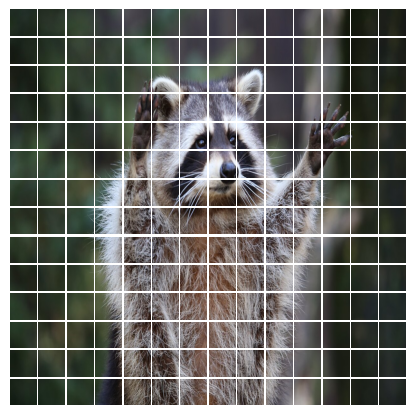

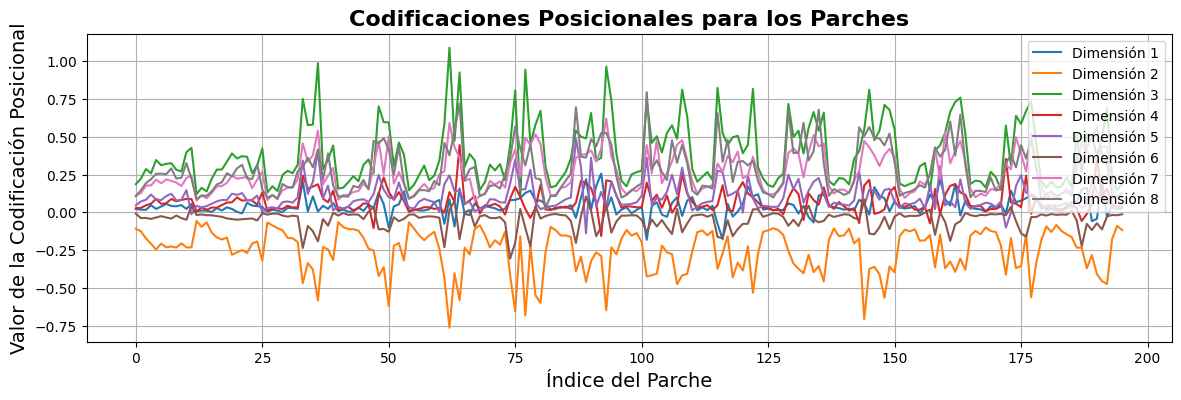

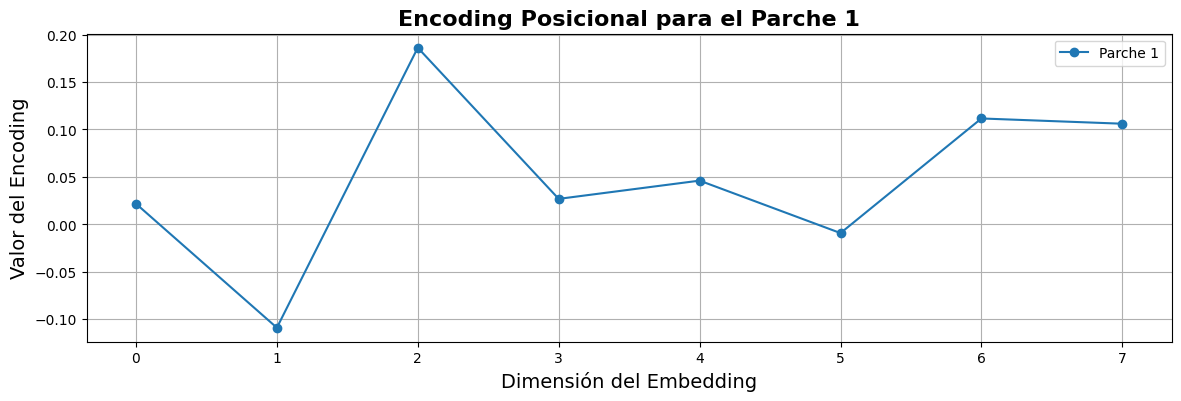

In [8]:
img_path = "raccoon.jpg"
img_size = 900
patch_size = 64
embed_dim = 8
patch_idx = (
    0  # El índice del parche para el cual queres visualiizar la codificación posicional
)

# Preprocesamiento
config = ConfigPreprocess(img_path, img_size, patch_size)

with Image.open(img_path) as img:
    print(f"Dimensiones de la imagen original: {img.size}")
    print(f"Canales: {img.mode}")


print(f"Imagen de prueba cargada: {config.img_path}")
print(f"Tamaño de la imagen: {config.img_size}x{config.img_size}")
print(f"Tamaño del parche: {config.patch_size}x{config.patch_size}")
print(f"Dimensiones de la imagen de prueba: {config.test_img.shape}")
# Extracción de parches y visualización
patches = config.extract_patches(
    config.test_img.squeeze(0)
)  # Eliminación de la dimensión de batch
Visualization.visualize_patches(patches)

# Generación de embeddings
embedded_patches = PatchEmbedding(img_size, patch_size, 3, embed_dim).to(config.device)
patches = embedded_patches(config.test_img)

# Codificación posicional
num_patches = (img_size // patch_size) ** 2
positional_encoding = PositionalEncoding(num_patches, embed_dim).to(config.device)
pos_embeddings = positional_encoding(patches)
Visualization.visualize_positional_encoding(pos_embeddings)
Visualization.visualize_single_patch_encoding(pos_embeddings, patch_idx)

> ⭐ <em><strong>Conclusión:</strong></em> Parecería que no tiene mucho sentido la codificación con `nn.Parameter`, pero esto es porque simplemente se está sumando un vector de 0 a la entrada. Luego de aprendidas las posiciones, debería tener más sentido el uso de la codificación (posicional) aprendida.